[Cranberry Sauce Riddler](https://fivethirtyeight.com/features/can-you-pass-the-cranberry-sauce/)

Prompt:
> To celebrate Thanksgiving, you and 19 of your family members are seated at a circular table (socially distanced, of course). Everyone at the table would like a helping of cranberry sauce, 
> which happens to be in front of you at the moment.
>
> Instead of passing the sauce around in a circle, you pass it randomly to the person seated directly to your left or to your right. They then do the same, passing it randomly either to the person to their left or right. This 
> continues until everyone has, at some point, received the cranberry sauce.
>
> Of the 20 people in the circle, who has the greatest chance of being the last to receive the cranberry sauce?

In [1]:
import numpy as np
from math import floor, ceil
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import OrderedDict

In [2]:
def table_dist(i, j, n_guests):
    '''
    Compute number of spaces between position i and j around a table 
    with n_guests
    
    Input: 
    i, j: position indices for two guests to be compared
    n_guests: the number of guests at table
           
    '''    
    diff = abs(i - j)
    
    if diff <= floor(n_guests / 2):
        return diff
    else:
        return n_guests - diff

In [3]:
def receiver_states(state, n_guests):
    '''
    Generate the states which can be reached from the current state.
    
    Input: 
    state: either a tuple of the form (current_pos, interval, n_moves)
      or an integer representing a terminal state
    n_guests: the number of guests at the table
    
    Return: 
    receptive_states: either a list of the possible transition states,
      if state is not terminal, and None if state is terminal (!!)    
    '''
    
    if state == (0, (0, 0), 0):
        receptive_states = [(n_guests-1, (n_guests-1, 0), 1), (1, (0, 1), 1)]
    
    elif type(state) == tuple:
        i, j = state[1]
        n_moves = state[2]
        
        if n_moves == n_guests - 2:
            if [i, j] == [0, n_guests - 2]:
                receptive_states = [n_guests - 1]
            elif [i, j] == [n_guests - 2, 0]:
                receptive_states = [1]            
            else:
                receptive_states = [(i + j) // 2]
        
        else:
            i_left  = (i - 1) % n_guests
            j_right = (j + 1) % n_guests
            receptive_states = [(i_left,  (i_left,  j), n_moves + 1), 
                                 (j_right, (i, j_right), n_moves + 1)]
    else:
        receptive_states = None   
        
    return receptive_states

In [4]:
def generate_states(n_guests):
    '''
    Generate the transition states for Cranberry passing in sorted order.
    
    Input: 
    n_guests: number of guests around the table
    
    Return: 
    transition_states: either a list of the possible transition states, 
      or None if the state is terminal (!)
    '''
    
    starting_state = (0, (0,0), 0)
    states = [starting_state]
    new_states = list(OrderedDict.fromkeys(states))
    
    for n_moves in range(1, n_guests):
        new_states = [s_new for s in new_states for s_new in 
                      receiver_states(s, n_guests)]
        new_states = list(OrderedDict.fromkeys(new_states))
        states.extend(new_states)
        
    # dictionary mapping state to its index
    n_states = len(states)    
    state_to_idx = dict(zip(states, range(n_states)))    
    
    return states, state_to_idx, n_states   

In [5]:
def drunkard_walk_transition_matrix(n_interval):
    # P is the transition matrix
    P = np.zeros((n_interval + 2, n_interval + 2))
    P[0, 0] = 1
    P[n_interval+1, n_interval+1] = 1
    for i in range(1, n_interval + 1):
        P[i, i-1] = 0.5
        P[i, i+1] = 0.5
    
    return P

In [6]:
def interval_exit_probabilities(n_interval, max_iter = 1e5, tol = 1e-8):
    '''
    Compute the probability that a random walk exits an interval of length 
    n from the left or right, conditioned on beginning at the left-most end of the 
    interval.
    
    Input: 
    n_interal: length of interval
    max_iter : maximum number of iterations to use
    
    Returns: 
    (p_near, p_far): where p_near = probability of left-exit, and
      p_far = probability of right-exit.
    '''
    
    # P is the transition matrix
    P = np.zeros((n_interval + 2, n_interval + 2))
    P[0, 0] = 1
    P[n_interval+1, n_interval+1] = 1
    for i in range(1, n_interval + 1):
        P[i, i-1] = 0.5
        P[i, i+1] = 0.5
        
    # iterate to compute the limiting distribution beginning from 
    # position 1(!). To do so, we start with pi = [0,1,0, ..., 0]
    # and iterate until P^T * pi = pi (within the specified tolerance)
    # so we keep track of pi at last step and compare to current step
    pi_old = np.zeros(n_interval + 2)
    pi_new = np.copy(pi_old)
    pi_new[1] = 1
    
    # iterate until convergence or we exceed max_iter
    i = 0
    while np.linalg.norm(pi_new - pi_old, 1) > tol and i < max_iter:
        pi_old = pi_new
        pi_new = np.dot(P.T, pi_old)
        i += 1
    
    # only return the probability of exiting left / right
    p_left = pi_new[0]
    p_right = pi_new[-1]
    
    return p_left, p_right

In [7]:
def cranberry_passing_transition_matrix(n_guests):
    '''
    Construct the cranberry passing transition matrix.
    
    Input: 
    n_guests: the number of guests at the table
    
    Returns: 
    (p_near, p_far) where p_near = probability of left-exit, and
      p_far = probability of right-exit.
    '''
    
    states, state_to_idx, n_states = generate_states(n_guests)

    # list of tuples, containing (p_near, p_far) interval exit probabilities
    exit_probs = [interval_exit_probabilities(i) for i in range(n_guests)]
    
    # compute transition matrix
    P = np.zeros((n_states, n_states))    
    for state in states:
        # non-absorbing states are encoded as tuples
        if type(state) == tuple:
            idx_state = state_to_idx[state]
            n_moves = state[2]
            receivers = receiver_states(state, n_guests)
            
            # if only one receiver, then transition is to a final state
            if len(receivers) == 1:
                state_child = receivers[0]
                idx_child = state_to_idx[state_child]
                P[idx_state, idx_child] = 1
            
            # non-terminal states
            if len(receivers) == 2:
                state_left, state_right = receivers
                
                # position on table for each state
                pos_state = state[0]
                pos_left = state_left[0]
                pos_right = state_right[0]                
                
                # determine if left or right is nearest position to the start state
                if table_dist(pos_left, pos_state, n_guests) < table_dist(pos_right, pos_state, n_guests):
                    state_near, state_far = state_left, state_right
                else:
                    state_near, state_far = state_right, state_left 
                
                # assign probability that we exit through either the near or far state
                idx_near, idx_far = state_to_idx[state_near], state_to_idx[state_far]
                p_near, p_far = exit_probs[n_moves + 1]
                P[idx_state, idx_near] = p_near
                P[idx_state, idx_far] = p_far
        
        # absorbing state
        else:
            idx_state = state_to_idx[state]            
            P[idx_state, idx_state] = 1

    return P    

In [8]:
def receive_cranberries_last_probabilities(n_guests, max_iter = 1e5, tol = 1e-8):
    '''
    Calculate the probability that each guest receives the cranberry sauce last, 
    given that the cranberry sauce starts at position 0.
    
    Input: 
    n_guests: the number of guests at the table
    max_iter: maximum number of iterations when estimating the terminal distribution
    tol: tolerance for convergence
    
    Returns: 
    pi_limit: exit distribution for terminal states (and 0)
    '''
    
    # determine all the possible states
    states, state_to_idx, n_states = list(generate_states(n_guests))        
           
    # iterate to compute the limiting distribution beginning from 
    # starting position (0, (0,0), 0)
    pi_old = np.zeros(n_states)
    pi_new = np.copy(pi_old)
    start_position = (0, (0, 0), 0)
    start_idx = state_to_idx[start_position]
    pi_new[start_idx] = 1
    
    # compute transition matrix
    P = cranberry_passing_transition_matrix(n_guests)
    
    # iterate until convergence or we exceed max_iter
    i = 0
    while np.linalg.norm(pi_new - pi_old, 1) > tol and i < max_iter:
        pi_old = pi_new
        pi_new = np.dot(P.T, pi_old)
        i += 1
        
    # extract the limiting distro only for terminal states
    pi_limit = np.zeros(n_guests)
    for k in range(1, n_guests):
        terminal_state_idx = state_to_idx[k]
        pi_limit[k] = pi_new[terminal_state_idx]
                        
    return pi_limit     

## Six Guests

In [9]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

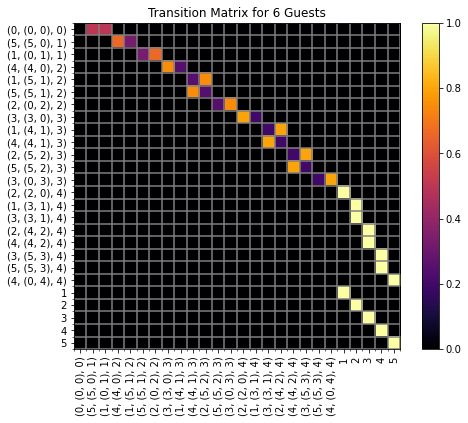

In [10]:
n_guests = 6
states, state_to_idx, n_states = generate_states(n_guests)
state_labels = [str(s) for s in states]
P = cranberry_passing_transition_matrix(n_guests)

# construct the plot
fig, ax = plt.subplots(figsize = (8,6), facecolor = 'w')
cm = ax.imshow(P,  cmap='inferno')

# major ticks with labels
ax.set_yticks(np.arange(n_states))
ax.set_xticks(np.arange(n_states))
ax.set_xticklabels(state_labels, rotation=90)
ax.set_yticklabels(state_labels, rotation=0)

# minor ticks + grid
ax.set_xticks(np.arange(-.5, n_states, 1), minor=True)
ax.set_yticks(np.arange(-.5, n_states, 1), minor=True)        
ax.grid(which='minor', color='grey', linestyle='-', linewidth=1.5)
ax.set_title("Transition Matrix for {} Guests".format(n_guests))
fig.colorbar(cm);

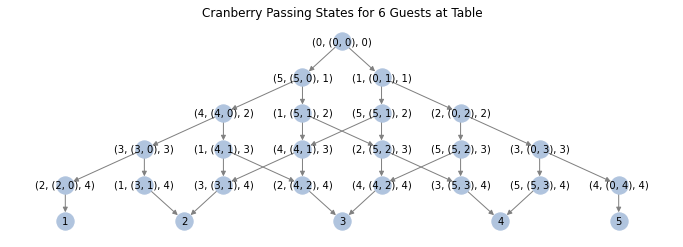

In [11]:
# adjacency matrix is the matrix whose i,j is 1 if there is a transition from i to j
# and 0 otherwise
P_adjacency = P > 0

# construct the adjacency graph (for this problem, it's a directed tree) 
# from the adjacency matrix
G = nx.from_numpy_matrix(P_adjacency, create_using=nx.DiGraph)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())), state_labels)))

# plot the adjacency graph
fig, ax = plt.subplots(figsize=(12, 4))
plt.title("Cranberry Passing States for {} Guests at Table".format(n_guests))
pos=graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, arrows=True, font_size=10, node_color='lightsteelblue', edge_color='grey')

In [12]:
def plot_state(state, n_guests, p=(0,0), r=1, ax = None, s=100, s_star=200):
    if ax is None:
        fig, ax = plt.subplots()
    
    if type(state) == tuple:
        k_left, k_right = state[1]
        n_passes = state[2]
        
        if k_left > k_right:
            idxs = [(k_left+i)%n_guests for i in range(n_passes+1)]
        
        else:
            idxs = [(k_right-i)%n_guests for i in range(n_passes+1)]
        
    else:
        idx_cur = state
        idxs = list(range(0, n_guests + 1))
            
    thetas_guest = np.linspace(-np.pi/2, 3*np.pi/2, n_guests + 1)
    xs_guest, ys_guest = p[0] + r * np.cos(thetas_guest), p[1] + r * np.sin(thetas_guest)
    
    thetas_table = np.linspace(0, 2*np.pi, 100)
    xs_table, ys_table = p[0] + r * np.cos(thetas_table), p[1] + r * np.sin(thetas_table)
    
    xs_received, ys_received = xs_guest[idxs], ys_guest[idxs]
    
    ax.plot(xs_table, ys_table, c='k', zorder=100)
    ax.scatter(xs_guest, ys_guest, c='lightgrey', edgecolor='k', zorder=101, s = s)
    ax.scatter(xs_received, ys_received, c='C0', edgecolor='k', zorder=102, s =s)
    
    if not type(state) == tuple:
        idx_last = state
        ax.scatter(xs_received[idx_last], ys_received[idx_last], marker='*', c='y', s=s_star, edgecolor='k', zorder=104)
    else:
        idx_curr = state[0]        
        ax.scatter(xs_guest[idx_curr], ys_guest[idx_curr], c='C3', edgecolor='k', zorder=103, s=s)


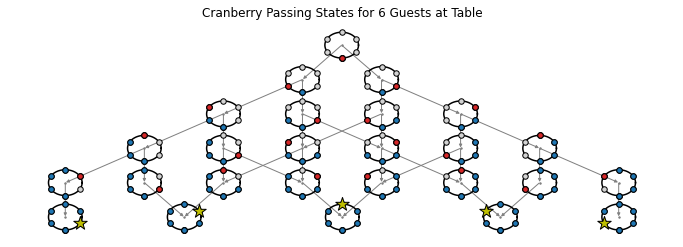

In [13]:
# plot the adjacency graph
fig, ax = plt.subplots(figsize=(12, 4))
plt.title("Cranberry Passing States for {} Guests at Table".format(n_guests))
pos=graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=False, arrows=True, arrowsize=6, font_size=10, node_size=2, node_color='grey', edge_color='grey')

for state, state_label in zip(states, state_labels):
    p = pos[state_label]
    plot_state(state, n_guests, p=p, r = 27, s=30, ax=ax)

[0.  0.2 0.2 0.2 0.2 0.2]


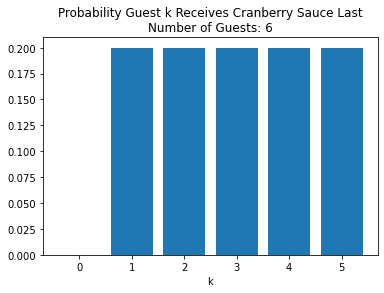

In [14]:
p_last = receive_cranberries_last_probabilities(n_guests)
fig, ax = plt.subplots(facecolor='w')
ax.bar(np.arange(n_guests), p_last)
ax.set_title('Probability Guest k Receives Cranberry Sauce Last\nNumber of Guests: {}'.format(n_guests))
ax.set_xlabel('k')
print(p_last)

## Twenty Guests

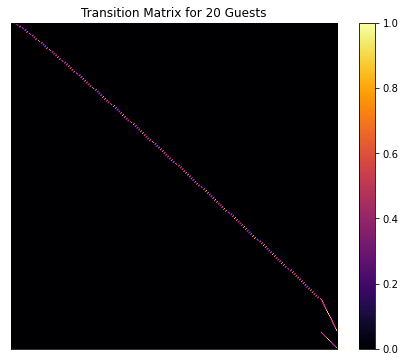

In [15]:
n_guests = 20
states, state_to_idx, n_states = generate_states(n_guests)
state_labels = [str(s) for s in states]
P = cranberry_passing_transition_matrix(n_guests)

# construct the plot
fig, ax = plt.subplots(figsize = (8,6), facecolor = 'w')
cm = ax.imshow(P,  cmap='inferno')

# major ticks with labels
ax.set_yticks([])
ax.set_xticks([])
ax.set_title("Transition Matrix for {} Guests".format(n_guests))
fig.colorbar(cm);

[0.         0.05263158 0.05263158 0.05263158 0.05263158 0.05263157
 0.05263157 0.05263157 0.05263157 0.05263157 0.05263157 0.05263157
 0.05263157 0.05263157 0.05263157 0.05263157 0.05263158 0.05263158
 0.05263158 0.05263158]


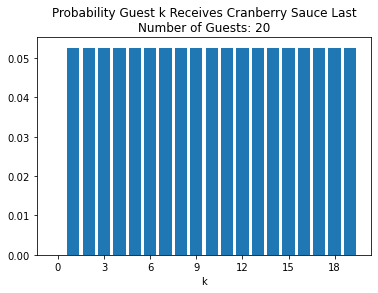

In [16]:
p_last = receive_cranberries_last_probabilities(n_guests)
fig, ax = plt.subplots(facecolor='w')
ax.bar(np.arange(n_guests), p_last)
ax.set_title('Probability Guest k Receives Cranberry Sauce Last\nNumber of Guests: {}'.format(n_guests))
ax.set_xlabel('k')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
print(p_last)